Here we demonstrate how to use the computational microscope model for image generation and adaptive optics scenarios

In [7]:
import numpy as np
import tensorflow as tf
from czt_tf import czt_factors, czt2d

from microscope_model import *
from wavefronts import Zernike

import matplotlib.pyplot as plt

%matplotlib inline

In [8]:
RES = 512
zernike = Zernike(resolution=RES)

Generating Zernikes on uniform grid...


## Generating images with microscope:

In [9]:
# Initialize microscope model with some parameters imaging 0.5 um beads:
mm = MicroscopeModel(zoom_level=14, simulation_resolution=RES, pmt_simulation=MicroscopeModel.PMT_POISSON,
                     pmt_gain=100.0, pmt_bgr_noise_lvl=0.005, crop_output=False)
mm.simulation.summary()
mm.bead_object_function(0.5*UM)

Microscope model is initialized with FOV of 14.285714285714286um at 512px resolution.
Initialized Debye model with NA=0.9475,
Angular aperture alpha=1.5858
Instantitaing CZT with float32 (complex64) floating point precision.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512)]        0         
_________________________________________________________________
circular_beam_1 (CircularBea (None, 512, 512, 2)       0         
_________________________________________________________________
microscope_objective_1 (Micr (None, 1, 512, 512)       786433    
_________________________________________________________________
pmt_simulator_poisson_1 (Pmt (None, 1, 512, 512)       3         
Total params: 786,436
Trainable params: 786,436
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Generate random modulations:
np.random.seed(42) # for consistent results
modulations = []
modulations.append(np.exp(0j*np.ones([RES, RES])))
for _ in range(5):
    mod = np.exp(1j*zernike.phase(np.random.randn(28))*0.1)
    modulations.append(mod)
modulations = np.array(modulations)

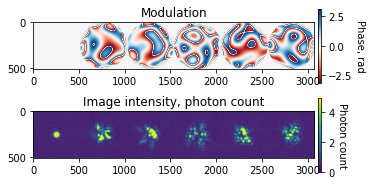

In [11]:
# Simulate foci and plot:

foci = mm.simulation(0.8*modulations)
plt.figure(figsize=(6,3))
plt.subplot(211), plt.imshow(np.angle(np.hstack(modulations)), cmap='RdBu'), plt.title('Modulation')
cb =  plt.colorbar(pad=0.01)
cb.set_label('Phase, rad', rotation = 270, verticalalignment='baseline')
plt.subplot(212), plt.imshow(np.hstack(foci[:,0])), plt.title('Image intensity, photon count')
plt.imshow(np.hstack(foci[:6,0]))
cb = plt.colorbar(pad=0.01)
cb.set_label('Photon count', rotation = 270, verticalalignment='baseline')

## Fitting model to the microscope

It has been sufficient to instantiate the model with appropriate parameters (pupil size, focal distance, wavelength, etc..) to get realistic images generated. Here we validate that by comparing model images with microscope measurements under the same parameters.

In [12]:
mm = MicroscopeModel(zoom_level=10, simulation_resolution=RES, pmt_simulation=MicroscopeModel.PMT_POISSON,
                     pmt_gain=50.0, pmt_bgr_noise_lvl=0.0005, crop_output=False)
mm.bead_object_function(0.5*UM)

Microscope model is initialized with FOV of 20.0um at 512px resolution.
Initialized Debye model with NA=0.9475,
Angular aperture alpha=1.5858
Instantitaing CZT with float32 (complex64) floating point precision.


In [13]:
# Make ramp sequence with varying attenuation:
N = 25
modulations = []
for i, amp in enumerate(np.sqrt(np.linspace(1, 0.1, N))):
    # amp is filtered with sqrt, since 2p intensity is proportonal to square of the excitation
    azim = 2*np.pi/N*i
    x, y = np.cos(azim), np.sin(azim)
    modulations.append(amp*np.exp(3j*zernike.phase([0, x, y])))
modulations = np.array(modulations)

# Simulate foci:
foci = mm.simulation(modulations*0.2)

#np.save('/home/ivan/AO2/ProbingModulations/mods.npy', modulations[:])
# Load microscope images:
d = np.load('circle_ramp.npz')
d, xx, yy, zz = d['d'], d['xx'], d['yy'], d['zz']

# Make maxprojections
max_proj_measured = np.max(np.mean(d[:, 0, ..., 2:], axis=-1), axis=0)
max_proj_sim = np.max(foci[:, 0], axis=0)
# Plot max_proj_sim, max_proj_measured:

Text(0.5, 0.98, 'Max projection of all foci stacked')

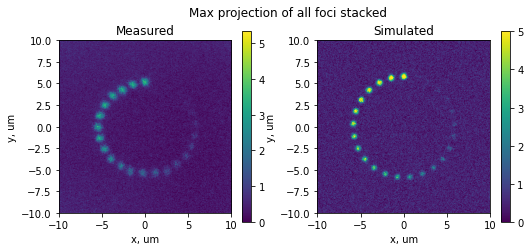

In [14]:
plt.figure(figsize=(8.5,3.5))
plt.subplot(121), plt.imshow(max_proj_measured, extent=[xx[0], xx[-1], yy[0],yy[-1]]),
plt.colorbar(), plt.xlabel('x, um'), plt.ylabel('y, um')
plt.title('Measured')

plt.subplot(122), plt.imshow(max_proj_sim, extent=[mm.xrange[0], mm.xrange[-1], mm.yrange[0], mm.yrange[-1]])
plt.colorbar(), plt.xlabel('x, um'), plt.ylabel('y, um')
plt.title('Simulated')

plt.suptitle('Max projection of all foci stacked')

In [15]:
# Make ramp sequence with varying modulations:
N = 10
modulations = []
for i, amp in enumerate(np.sqrt(np.linspace(1, 0.1, N))):
    azim = 2*np.pi/N*i
    x, y = np.cos(azim)*1.5, np.sin(azim)*1.8
    cff = np.zeros([N*2])
    cff[1:4] = [x, y, +0.1]
    cff[i+4] = 0.1
    modulations.append(np.exp(2j*zernike.phase(cff)))
    
modulations = np.array(modulations)
np.save('/home/ivan/AO2/ProbingModulations/mods.npy', modulations[:])

mm.bead_object_function(1.0*UM)
foci = mm.simulation(0.7*modulations)
mm.pmt.gain.assign(50)

#plt.imshow(np.max(foci[:, 0], axis=0)), plt.title('Max projection of foci with varying modulation and offset')

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=50.0>

## Finding aberration with model:

This is a demonstration of aberration identification based on sample probing, when guidestars (beads) are imaged. 

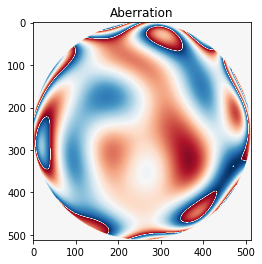

In [16]:
# Generate aberration and probing modulations:
np.random.seed(42) # For consistency

RES = 512
N_ABERRATION_MODES = 45  # Complexity of aberration, number of modes used to generate it.

N_PROBES = 28            # Number of measurements used to find the aberration
N_PROBE_MODES = 28       # Complexity of probing modulations


aberration = zernike.phase(np.random.randn(N_ABERRATION_MODES)*0.05)
plt.imshow((3.14+aberration)%6.28, cmap='RdBu'), plt.title('Aberration')

modulations = []
modulations.append(np.exp(0j*np.ones([RES, RES])))
for _ in range(N_PROBES-1):
    mod = np.exp(1j*zernike.phase(np.random.randn(N_PROBE_MODES))*0.1)
    modulations.append(mod)
probes = np.array(modulations)

Microscope model is initialized with FOV of 14.285714285714286um at 256px resolution.
Initialized Debye model with NA=0.9475,
Angular aperture alpha=1.5858
Instantitaing CZT with float32 (complex64) floating point precision.
ImageCropper crops to 256


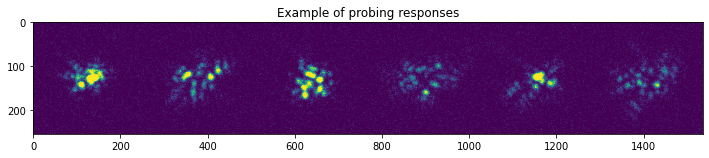

In [17]:
# Simulating aberrtaion probing:

mm = MicroscopeModel(zoom_level=7, simulation_resolution=RES, pmt_simulation=MicroscopeModel.PMT_POISSON,
                     pmt_gain=100.0, pmt_bgr_noise_lvl=0.0005)
mm.mo.aberration.assign(aberration) # Assign the aberration to the model
mm.bead_object_function(0.5*UM)

responses = mm.simulation(probes).numpy()

plt.figure(figsize=(12, 4)), plt.title('Example of probing responses')
plt.imshow(np.hstack(responses[:6,0]))

In [31]:
# Initilize model to optimize, same parameters, but PMT gain unknown, no aberration, PMT nonlinearity simulated WITHOUT Poisson:

mm = MicroscopeModel(zoom_level=7, simulation_resolution=RES, pmt_simulation=MicroscopeModel.PMT_NONLINEARITY_ONLY)
mm.bead_object_function(0.5*UM)

Microscope model is initialized with FOV of 14.285714285714286um at 256px resolution.
Initialized Debye model with NA=0.9475,
Angular aperture alpha=1.5858
Instantitaing CZT with float32 (complex64) floating point precision.


/data/ivan/Dropbox (Stiftung Caesar)/AO Paper DDAO/source/microscope_model.py:185: RuntimeWarning: invalid value encountered in sqrt
  self.kzz_px = np.sqrt(k0_px ** 2 - krr_px ** 2)


ImageCropper crops to 256


In [32]:
#from time import time, sleep

In [35]:
# Initialize optimization:

BS = 8 # Batch size
PSF_CROP = 256 # Size of simulated images

# Variables to keep inputs and outputs. We are not using the standard model.fit() training loop
tf_targs = tf.Variable(np.zeros([BS, 1, PSF_CROP, PSF_CROP]), dtype=tf.float32)
tf_inp = tf.Variable(np.zeros([BS, RES, RES]), dtype=tf.complex64)

def shuffle_batch():
    """Helper funciton to populate simulated batch with random samples
    """
    ind = np.random.choice(range(N_PROBES), BS, replace = False)
    tf_inp.assign(probes[ind])
    tf_targs.assign(responses[ind])

@tf.function
def cor_tf(a, b):
    """ Image corellation coefficient, used for loss
    """
    n = np.product(a.shape)
    mean_a = tf.reduce_mean(a)
    mean_b = tf.reduce_mean(b)
    std_a = tf.sqrt(tf.reduce_sum(tf.square(a-mean_a))/(n-1))
    std_b = tf.sqrt(tf.reduce_sum(tf.square(b-mean_b))/(n-1))
    return tf.reduce_sum((a - mean_a)*(b-mean_b))/(n-1)/std_a/std_b

cor = tf.Variable(0.0, dtype=tf.float32) # Variable for intemiediate result storing and optimization monitoring
L1 = tf.keras.regularizers.L1(1.0/PSF_CROP**2)
def makeloss():
    """Make sure dimensions of arguments of cov_tf match! Otherwise weird things happen as it still would compute!
    """
    @tf.function
    def loss():
        sim = mm.simulation(tf_inp)        
        cor_ = cor_tf(sim, tf_targs)
        cor.assign(cor_)
        return -cor_-mm.mo.total_intensity+L1(mm.mo.object_function)
    return loss
    
loss = makeloss()
    
shuffle_batch()

optimizer = tf.keras.optimizers.Adam(lr=0.1)

In [36]:
# Trainable parameters, here we include gain as well as it influences image genertion
trainable = [mm.pmt.gain, mm.mo.aberration]
t1 = time()
for _ in range(200):
    with tf.GradientTape() as tape:
        l = loss()
        gradients = tape.gradient(l, trainable)
        optimizer.apply_gradients(zip(gradients, trainable))

    shuffle_batch()
    print(_, f'cor: {cor.numpy()}, loss: {l.numpy()}', end='\r')
    
correction = -mm.mo.aberration.numpy()
t2 = time()
print(t2-t1)

129.13896894454956928878784, loss: -3.5818982124328613


In [78]:
# Run simulation without and with correction
mm.mo.aberration.assign(aberration) # Temporary assign aberration
aberrated = mm.simulation(probes[:1]).numpy()[0,0]
corrected = mm.simulation(np.expand_dims(np.exp(1j*correction), 0)).numpy()[0,0]
mm.mo.aberration.assign(-correction);
# plot aberrated, corrected:

(<AxesSubplot:title={'center':'Corrected'}>,
 Text(0.5, 1.0, 'Corrected'),
 <matplotlib.colorbar.Colorbar at 0x7fa378043d68>)

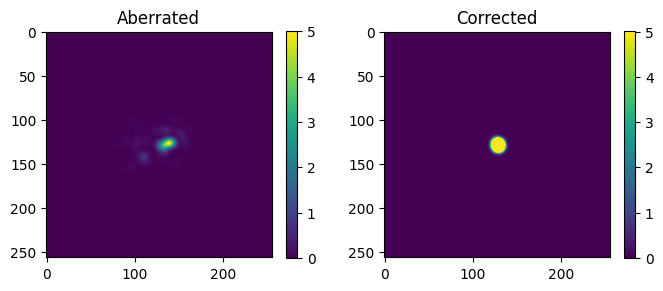

In [79]:
plt.figure(figsize=(8,3))
plt.subplot(121), plt.imshow(aberrated), plt.title('Aberrated'), plt.colorbar()
plt.subplot(122), plt.imshow(corrected), plt.title('Corrected'), plt.colorbar()

## Finding aberration with object function

This is a demonstration of aberration identification based on sample probing, when continuous object is imaged. 

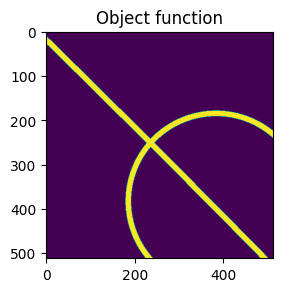

In [86]:
# Constructing object function

def circle(radius=1.0, center=(0,0)):
    cx, cy = center
    ii, jj = np.mgrid[-1:1:RES*1j, -1:1:RES*1j]
    ret = np.zeros([RES, RES])
    ret[np.sqrt((ii-cy)**2+(jj-cx)**2)<radius] = 1.0
    return ret

of = circle(radius=0.8, center=(0.5, 0.5))
of -= circle(radius=0.75, center=(0.5, 0.5))
of += circle(radius=141.4, center=(-100, 100))
of -= circle(radius=141.35, center=(-100, 100))
of[of>0.5] = 1.0
plt.imshow(of), plt.title('Object function');

(<matplotlib.image.AxesImage at 0x7fa3801e5c18>, Text(0.5, 1.0, 'Aberration'))

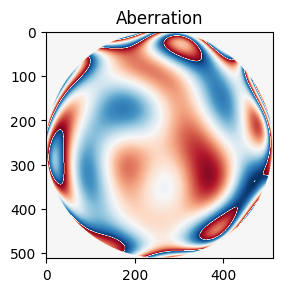

In [96]:
# Generate aberration and probing modulations:

np.random.seed(42) # For consistency

RES = 512
N_ABERRATION_MODES = 45  # Complexity of aberration, number of modes used to generate it.

N_PROBES = 28            # Number of measurements used to find the aberration
N_PROBE_MODES = 28       # Complexity of probing modulations


aberration = zernike.phase(np.random.randn(N_ABERRATION_MODES)*0.05)

modulations = []
modulations.append(np.exp(0j*np.ones([RES, RES])))
for _ in range(N_PROBES-1):
    mod = np.exp(1j*zernike.phase(np.random.randn(N_PROBE_MODES))*0.1)
    modulations.append(mod)
probes = np.array(modulations)

plt.imshow((3.14+aberration)%6.28, cmap='RdBu'), plt.title('Aberration')

Microscope model is initialized with FOV of 14.285714285714286um at 256px resolution.
Initialized Debye model with NA=0.9475,
Angular aperture alpha=1.5858
Instantitaing CZT with float32 (complex64) floating point precision.
ImageCropper crops to 256


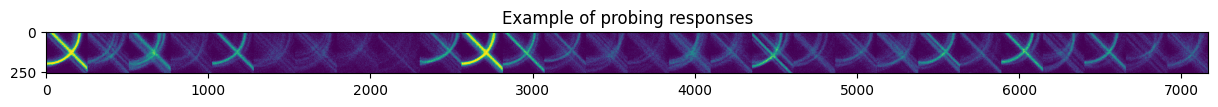

In [88]:
# Simulating aberrtaion probing:

mm = MicroscopeModel(zoom_level=7, simulation_resolution=RES, pmt_simulation=MicroscopeModel.PMT_POISSON,
                     pmt_gain=3.0, pmt_bgr_noise_lvl=0.0005, object_function=of)
mm.mo.aberration.assign(aberration) # Assign the aberration to the model

responses = mm.simulation(probes).numpy()

plt.figure(figsize=(15,3)), plt.title('Example of probing responses')
plt.imshow(np.hstack(responses[:,0]))

In [89]:
ind_brightes = np.argmax(np.sum(responses, axis=tuple(range(1, len(responses.shape)))))
ind_brightes # checking the brightest sample and using it as initial object function, and its modulation as aberration

init_of = np.zeros([RES, RES])
init_of[RES//2-PSF_CROP//2:RES//2+PSF_CROP//2, RES//2-PSF_CROP//2:RES//2+PSF_CROP//2] = responses[ind_brightes][0]
init_of = np.flip(np.flip(init_of, 0), 1) # Object funciton is flipped wrt the image
init_abb = -np.angle(modulations[ind_brightes])

(<AxesSubplot:title={'center':'Estimate of object function'}>,
 Text(0.5, 1.0, 'Estimate of object function'))

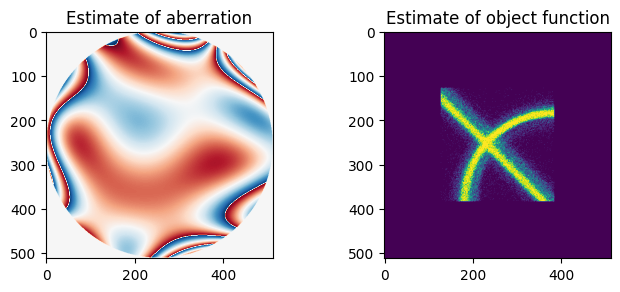

In [91]:
plt.figure(figsize=(8,3))
plt.subplot(121), plt.imshow(init_abb, cmap='RdBu'), plt.title('Estimate of aberration')
plt.subplot(122), plt.imshow(init_of), plt.title('Estimate of object function')

In [93]:
# Initilize model to optimize, same parameters, but PMT gain unknown, no aberration, PMT nonlinearity simulated WITHOUT Poisson:
mm = MicroscopeModel(zoom_level=7, simulation_resolution=RES, pmt_simulation=MicroscopeModel.PMT_NONLINEARITY_ONLY)

# Assign aberration and object function estimates:
mm.mo.aberration.assign(init_abb)
mm.mo.object_function.assign(init_of);

# Initialize optimization:

BS = 8 # Batch size
PSF_CROP = 256 # Size of simulated images

# Variables to keep inputs and outputs. We are not using the standard model.fit() training loop
tf_targs = tf.Variable(np.zeros([BS, 1, PSF_CROP, PSF_CROP]), dtype=tf.float32)
tf_inp = tf.Variable(np.zeros([BS, RES, RES]), dtype=tf.complex64)

def shuffle_batch():
    """Helper funciton to populate simulated batch with random samples
    """
    ind = np.random.choice(range(N_PROBES), BS, replace = False)
    tf_inp.assign(probes[ind])
    tf_targs.assign(responses[ind])

@tf.function
def cor_tf(a, b):
    """ Image corellation coefficient, used for loss
    """
    n = np.product(a.shape)
    mean_a = tf.reduce_mean(a)
    mean_b = tf.reduce_mean(b)
    std_a = tf.sqrt(tf.reduce_sum(tf.square(a-mean_a))/(n-1))
    std_b = tf.sqrt(tf.reduce_sum(tf.square(b-mean_b))/(n-1))
    return tf.reduce_sum((a - mean_a)*(b-mean_b))/(n-1)/std_a/std_b

cor = tf.Variable(0.0, dtype=tf.float32) # Variable for intemiediate result storing and optimization monitoring
L1 = tf.keras.regularizers.L1(1.0/PSF_CROP**2)
def makeloss():
    """Make sure dimensions of arguments of cov_tf match! Otherwise weird things happen as it still would compute!
    """
    @tf.function
    def loss():
        sim = mm.simulation(tf_inp)        
        cor_ = cor_tf(sim, tf_targs)
        cor.assign(cor_)
        return -cor_-mm.mo.total_intensity+L1(mm.mo.object_function)
    return loss
    
loss = makeloss()
    
shuffle_batch()

optimizer = tf.keras.optimizers.Adam(lr=0.1)

Microscope model is initialized with FOV of 14.285714285714286um at 256px resolution.
Initialized Debye model with NA=0.9475,
Angular aperture alpha=1.5858
Instantitaing CZT with float32 (complex64) floating point precision.
ImageCropper crops to 256


In [94]:
# Trainable parameters, here we include gain as well as it influences image genertion
trainable = [mm.pmt.gain, mm.mo.aberration, mm.mo.object_function] # Note we optmiize object function as well

for _ in range(100):
    with tf.GradientTape() as tape:
        l = loss()
        gradients = tape.gradient(l, trainable)
        optimizer.apply_gradients(zip(gradients, trainable))

    shuffle_batch()
    print(_, f'cor: {cor.numpy()}, loss: {l.numpy()}', end='\r')
    
correction = -mm.mo.aberration.numpy()

Microscope model is initialized with FOV of 14.285714285714286um at 256px resolution.
Initialized Debye model with NA=0.9475,
Angular aperture alpha=1.5858
Instantitaing CZT with float32 (complex64) floating point precision.
ImageCropper crops to 256


(<AxesSubplot:title={'center':'Corrected'}>,
 Text(0.5, 1.0, 'Corrected'),
 <matplotlib.colorbar.Colorbar at 0x7fa378766fd0>)

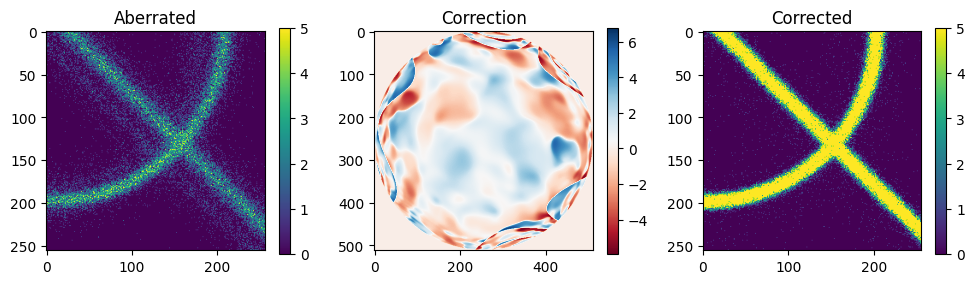

In [95]:
mm = MicroscopeModel(zoom_level=7, simulation_resolution=RES, pmt_simulation=MicroscopeModel.PMT_POISSON,
                     pmt_gain=1.0, pmt_bgr_noise_lvl=0.0005, object_function=of)

mm.mo.aberration.assign(aberration)
mm.mo.object_function.assign(of)
aberrated = mm.simulation(probes[:1]).numpy()[0,0]
corrected = mm.simulation(np.expand_dims(np.exp(1j*correction), 0)).numpy()[0,0]

plt.figure(figsize=(12,3))
plt.subplot(131), plt.imshow(aberrated), plt.title('Aberrated'), plt.colorbar()
plt.subplot(132), plt.imshow(correction, cmap='RdBu'), plt.title('Correction'), plt.colorbar()
plt.subplot(133), plt.imshow(corrected), plt.title('Corrected'), plt.colorbar()